# Example: run MultiSolSegment and validate
This examples hows how to download the weights for MultiSolSegment, run it on an image to segment crack, dark and busbar masks. Then use pvimage to look at crack count and parameters

In [ ]:
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.nn import DataParallel

import seaborn as sns
from zipfile import ZipFile
from io import BytesIO

from pvcracks.utils import viz_functions, train_functions, img_functions
from pvcracks.utils.unet_model import construct_unet

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import requests

from pvimage import features

In [2]:
if not (str(Path.cwd()).split("/")[-1].startswith("pvcracks")):
    project_root = Path.cwd().parents[1]
    os.chdir(project_root)  # now cwd is .../pvcracks

In [3]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

## Step 1: Download Model

DOI - https://doi.org/10.21948/2997859  
Direct Link - https://datahub.duramat.org/dataset/24d7ed98-956e-4ebc-bf21-6584ecec2ff1/resource/e6d5dee2-0aef-439e-978c-d8c572e7039e/download/model.pt

In [4]:
# if you have have already downloaded model weights, replace this with the local path
# weight_path = "multisolsegment.pt"
weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/final_model_strict_holdout.pt"

if os.path.exists(weight_path):
    print("Weights already downloaded.")
else:
    response = requests.get(
        "https://datahub.duramat.org/dataset/24d7ed98-956e-4ebc-bf21-6584ecec2ff1/resource/e6d5dee2-0aef-439e-978c-d8c572e7039e/download/model.pt"
    )
    with open(weight_path, "wb") as f:
        f.write(response.content)

Weights already downloaded.


## Step 2: Download and Load Images

DOI - https://doi.org/10.21948/2587738  
Direct Link - https://datahub.duramat.org/dataset/5e7587ad-6ad1-4d6f-8432-70940a6d7ca1/resource/8f12be45-b929-4f5c-9400-84dde27b0e90/download/labeledelcells.zip

In [5]:


# if you have have already downloaded data, replace this with the local path
# files_root = "labeled_image_data/"
files_root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/"


if os.path.exists(files_root):
    print("Images already downloaded.")
else:
    url = "https://datahub.duramat.org/dataset/5e7587ad-6ad1-4d6f-8432-70940a6d7ca1/resource/8f12be45-b929-4f5c-9400-84dde27b0e90/download/labeledelcells.zip"

    os.makedirs(files_root, exist_ok=True)

    resp = requests.get(url)
    resp.raise_for_status()

    with ZipFile(BytesIO(resp.content)) as z:
        z.extractall(path=files_root)

Images already downloaded.


## Step 3: Load in everything

In [ ]:

category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}

root = Path(files_root)

train_dataset, val_dataset = train_functions.load_dataset(root)
val_loader: DataLoader[img_functions.SolarDataset] = DataLoader(
    val_dataset, batch_size=1, shuffle=False
)
device, model = train_functions.load_device_and_model(
    category_mapping, existing_weight_path=weight_path
)

## Step 5: Pick image and threshold

Index is what image to run this model on.  

Threshold is what confidence % we want to code as an actual detection target, rather than just background noise.

In [7]:
category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}

threshold = 0.5  # default
idx = 171

## Step 6: Inference and Show

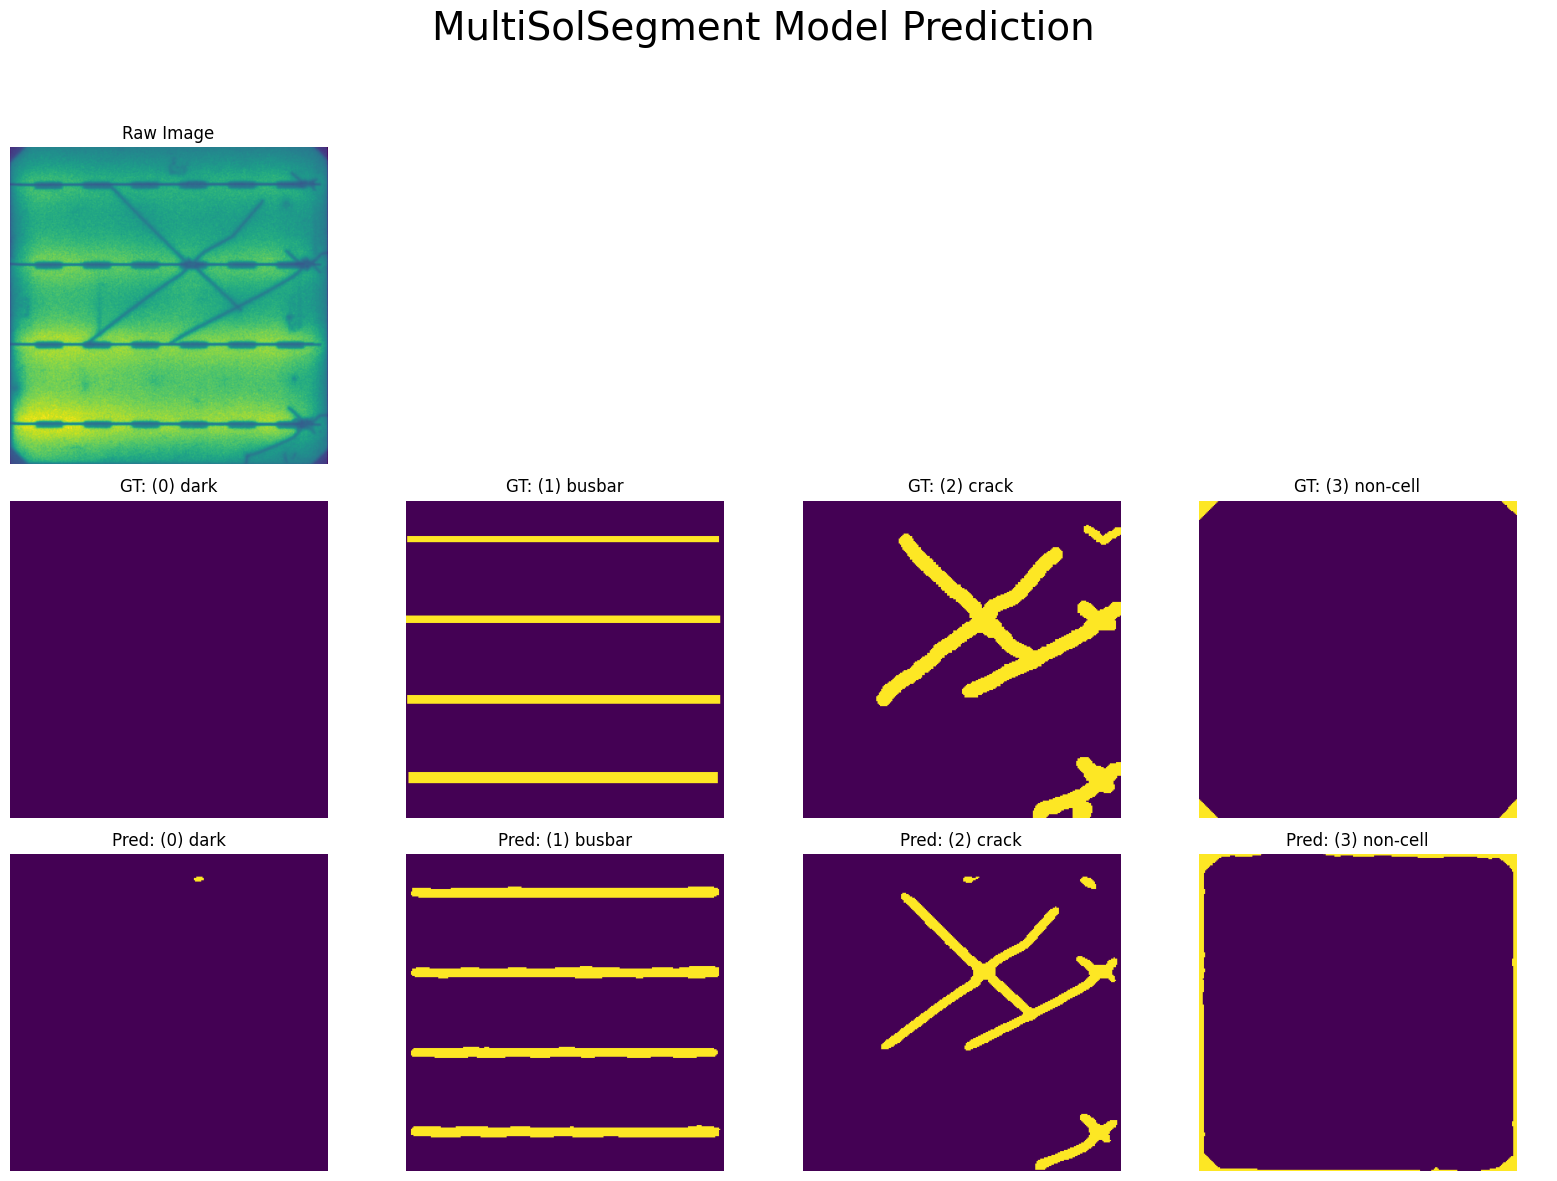

In [8]:
viz_functions.channeled_inference_and_show(
    val_loader,
    device,
    model,
    category_mapping,
    idx,
    threshold,
    custom_title="MultiSolSegment Model Prediction",
    save_path="mss_model_prediction.png",
)

## Step 7: Investigate dark area %

In [10]:
def channel_activation_percentages(mask, category_mapping):
    """
    Calculate the percentage of pixels activated for each channel in a multi-hot mask.

    Args:
        mask: 3D array-like of shape (n_channels, height, width) containing multi-hot activations.
        category_mapping (dict): Mapping from channel index to class name. The iteration order
            defines the channel order in the mask tensor.

    Returns:
        dict: Mapping from class name to percentage (0-100) of activated pixels in that channel.
    """

    mask_np = np.asarray(mask)

    if mask_np.ndim != 3:
        raise ValueError(
            f"Expected a 3D mask of shape (channels, height, width); got {mask_np.shape}."
        )

    n_channels, height, width = mask_np.shape
    total_pixels = height * width

    if total_pixels == 0:
        raise ValueError("Mask must contain at least one pixel.")

    percentages = {}
    for channel_idx, class_name in category_mapping.items():
        if channel_idx >= n_channels:
            raise ValueError(
                f"Channel index {channel_idx} for class '{class_name}' is out of bounds "
                f"for mask with {n_channels} channel(s)."
            )
        channel_activation = mask_np[channel_idx].sum()
        percentages[class_name] = (
            float(channel_activation) / float(total_pixels) * 100.0
        )

    return percentages


def print_channel_activation_comparison(
    gt_percentages, pred_percentages, category_mapping
):
    print("Channel activation comparison (% of image):\n")
    print(
        f"{'Class':<20} {'Ground Truth (%)':>18} {'Predicted (%)':>18} {'Δ (Pred-GT)':>15}"
    )
    print("-" * 75)

    gt_sum = 0
    pred_sum = 0

    for _, class_name in category_mapping.items():
        gt_val = gt_percentages[class_name]
        pred_val = pred_percentages[class_name]
        delta = pred_val - gt_val

        print(f"{class_name:<20} {gt_val:>18.2f} {pred_val:>18.2f} {delta:>15.2f}")

        gt_sum += gt_val
        pred_sum += pred_val

    # Remaining (solar cell)
    gt_rem = 100 - gt_sum
    pred_rem = 100 - pred_sum
    delta_rem = pred_rem - gt_rem

    print("-" * 75)
    print(
        f"{'Remaining (solar cell)':<20} {gt_rem:>18.2f} {pred_rem:>18.2f} {delta_rem:>15.2f}"
    )
    print()

In [11]:

img, mask = val_dataset.__getitem__(idx)
img = img.to(device)

logits = model(img.unsqueeze(0)).detach().cpu()
probs = torch.sigmoid(logits)
pred_mask = (probs > threshold).float().squeeze(0).numpy()

gt_mask = mask.cpu().numpy()

gt_percentages = channel_activation_percentages(gt_mask, category_mapping)
pred_percentages = channel_activation_percentages(pred_mask, category_mapping)

print_channel_activation_comparison(gt_percentages, pred_percentages, category_mapping)

Channel activation comparison (% of image):

Class                  Ground Truth (%)      Predicted (%)     Δ (Pred-GT)
---------------------------------------------------------------------------
dark                               0.00               0.04            0.04
busbar                            10.34              11.89            1.55
crack                             11.41               6.82           -4.59
non-cell                           0.69               4.57            3.87
---------------------------------------------------------------------------
Remaining (solar cell)              77.55              76.68           -0.87



## Step 8: Crack mask features with PVImage

Extract predicted crack masks, compute crack statistics with PVImage, and visualize the distribution of key metrics.


In [ ]:
def violinplt(data, palette=None, figsize=(5, 4), y_axis_log=False):

    # Coerce to DataFrame so .mean() and column names behave
    if isinstance(data, pd.Series):
        data = data.to_frame()
    elif not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    fig, ax = plt.subplots(figsize=figsize)

    # Seaborn API: no widths/showmeans/showmedians/showextrema here
    # Use inner="quartile" to show quartiles; cut=0 to avoid extrapolation
    sns.violinplot(
        data=data,
        ax=ax,
        palette=palette,
        inner="quartile",
        cut=0,
        linewidth=1,
    )

    # Overlay means as points
    means = data.mean().to_numpy()
    x_pos = np.arange(len(means))
    ax.scatter(x_pos, means, zorder=3)

    # Prepare mean labels
    nobs = [f"{m:.2f}" for m in means]

    # Place mean labels slightly above the point
    y_offset = 0.03 * (
        np.nanmax(means) - np.nanmin(means) if np.all(np.isfinite(means)) else 1.0
    )
    y_offset = 0
    
    if len(x_pos) > 3:
        for i in x_pos:
            t = ax.text(
                i,
                means[i] + y_offset,
                nobs[i],
                ha="center",
                va="bottom",
                fontsize=10,
                color="black",
                weight="semibold",
            )
            # subtle white box for readability
            t.set_bbox(
                dict(
                    facecolor="white",
                    alpha=0.5,
                    edgecolor="none",
                    boxstyle="round,pad=0.15",
                )
            )
        # Rotate tick labels cleanly
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    else:
        for i in x_pos:
            ax.text(
                i,
                means[i] + y_offset,
                nobs[i],
                ha="center",
                va="bottom",
                fontsize=12,
                color="black",
                weight="semibold",
            )

    ax.set_ylabel("Value")
    ax.set_xlabel("")
    if y_axis_log:
        ax.set_yscale("log")
    ax.margins(x=0.05)
    fig.tight_layout()
    return fig

In [13]:
m_idx = len(val_dataset)  # indices to process
masks_mss = []
impaths_mss = []

for i in range(m_idx):
    img, _ = val_dataset.__getitem__(i)
    img = img.to(device)
    img_path = val_dataset.get_img_path(i)

    # model inference
    logits = model(img.unsqueeze(0)).detach().cpu()
    probs = torch.sigmoid(logits)
    pred_mask = (probs > threshold).float().squeeze(0).numpy()  # (n_classes, H, W)

    # Extract crack channel (index 2) and convert to uint8 [0,255]
    crack_mask = (pred_mask[2] * 255).astype(np.uint8)

    masks_mss.append(crack_mask)
    impaths_mss.append(str(img_path))

# Build dataframe of image paths expected by feature_extraction_crack_mask
df_info_mss = pd.DataFrame({"impath": impaths_mss})

if os.path.exists("df_features_mss.pickle"):
    df_features_mss = pd.read_pickle("df_features_mss.pickle")
else:
    # Run PVImage feature extraction across all predicted crack masks
    df_features_mss = features.feature_extraction_crack_mask(masks_mss, df_info_mss)
    df_features_mss["count_features"] = df_features_mss.groupby("cell_number")[
        "cell_number"
    ].transform("count")
    df_features_mss.to_pickle("df_features_mss.pickle")


df_features_mss_count = df_features_mss.sort_values(by="cell_number").drop_duplicates(
    "cell_number", keep="first"
)
df_features_mss_count.reset_index(drop=True, inplace=True)

features_counted_mss = pd.concat(
    [df_features_mss_count["count_features"]], axis=1, ignore_index=True
)
features_counted_mss.columns = ["Original"]

print(
    f"Processed {len(masks_mss)} images, extracted {len(features_counted_mss)} feature rows."
)

# vp = violinplt(features_counted_mss[["Original"]], figsize=(5, 4))

Processed 468 images, extracted 119 feature rows.


In [14]:
scaler = MinMaxScaler()
columns_to_normalize = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]

df_features_mss_norm = df_features_mss[columns_to_normalize]
df_features_mss_norm[columns_to_normalize] = scaler.fit_transform(df_features_mss_norm)
# fig = violinplt(
#     df_features_mss_norm[
#         [
#             " prop.perimeter",
#             " slope",
#             " prop.area",
#             " prop.orientation",
#         ]
#     ],
#     figsize=None,
# )

## Step 10: PVImage stats for ground truth crack masks

In [15]:
gt_masks = []
gt_impaths = []

for i in range(m_idx):
    _, gt_mask = val_dataset.__getitem__(i)
    img_path = val_dataset.get_img_path(i)

    crack_mask_gt = (gt_mask.cpu().numpy()[2] * 255).astype(np.uint8)

    gt_masks.append(crack_mask_gt)
    gt_impaths.append(str(img_path))

df_info_gt = pd.DataFrame({"impath": gt_impaths})

df_features_gt = features.feature_extraction_crack_mask(gt_masks, df_info_gt)
df_features_gt["count_features"] = df_features_gt.groupby("cell_number")[
    "cell_number"
].transform("count")

df_features_gt_count = df_features_gt.sort_values(by="cell_number").drop_duplicates(
    "cell_number", keep="first"
)
df_features_gt_count.reset_index(drop=True, inplace=True)


features_counted_gt = pd.concat(
    [df_features_gt_count["count_features"]], axis=1, ignore_index=True
)
features_counted_gt.columns = ["Ground Truth"]

print(
    f"Processed {len(gt_masks)} ground-truth images, extracted {len(features_counted_gt)} feature rows."
)

# vp = violinplt(features_counted_gt[["Ground Truth"]], figsize=(5, 4))

Processed 468 ground-truth images, extracted 119 feature rows.


In [16]:
scaler = MinMaxScaler()
df_features_gt_norm = df_features_gt[columns_to_normalize]
df_features_gt_norm[columns_to_normalize] = scaler.fit_transform(df_features_gt_norm)

# fig = violinplt(
#     df_features_gt_norm[
#         [
#             " prop.perimeter",
#             " slope",
#             " prop.area",
#             " prop.orientation",
#         ]
#     ],
#     figsize=None,
# )

## Step 11: Compare PVImage stats (predicted vs. ground truth)

Join the PVImage outputs to see how the model's crack counts and shape metrics differ from the labeled data.


In [17]:
mss_counts = df_features_mss.groupby("cell_number").size().rename("mss_crack_count")
gt_counts = df_features_gt.groupby("cell_number").size().rename("gt_crack_count")

count_comparison_mss_gt = (
    pd.concat([mss_counts, gt_counts], axis=1).fillna(0).astype(int).reset_index()
)
count_comparison_mss_gt.columns = ["cell_number", "mss_crack_count", "gt_crack_count"]

# vp = violinplt(
#     count_comparison_mss_gt[["mss_crack_count", "gt_crack_count"]].rename(
#         columns={
#             "mss_crack_count": "MultiSolSegment Prediction",
#             "gt_crack_count": "Ground Truth",
#         }
#     ),
#     figsize=(6, 4),
# )

In [18]:
feature_cols = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
feature_comparison = pd.DataFrame(
    {
        "Predicted_mean": df_features_mss_norm[feature_cols].mean(),
        "GroundTruth_mean": df_features_gt_norm[feature_cols].mean(),
    }
)
feature_comparison["abs_diff"] = (
    feature_comparison["Predicted_mean"] - feature_comparison["GroundTruth_mean"]
).abs()

In [19]:
feature_pairs_mss_gt = []

for col in feature_cols:
    if (
        col not in df_features_mss_norm.columns
        or col not in df_features_gt_norm.columns
    ):
        print(f"Skipping {col}: not found in features dataframe.")
        continue

    label = col.strip()
    mss_pred = df_features_mss_norm[col].reset_index(drop=True)
    gt = df_features_gt_norm[col].reset_index(drop=True)

    max_len = max(len(mss_pred), len(gt))
    if max_len == 0:
        print(f"Skipping {label}: no data to plot.")
        continue

    mss_pred = mss_pred.reindex(range(max_len))
    gt = gt.reindex(range(max_len))

    feature_pairs_mss_gt.append(
        pd.DataFrame(
            {
                f"MSS Predicted {label}": mss_pred,
                f"Ground Truth {label}": gt,
            }
        )
    )

if not feature_pairs_mss_gt:
    print("No feature data available for violin plots.")
    feature_violin_df = pd.DataFrame()
else:
    feature_violin_mss_gt_df = pd.concat(feature_pairs_mss_gt, axis=1)
    feature_violin_mss_gt_df = feature_violin_mss_gt_df.apply(pd.to_numeric, errors="coerce")
    feature_violin_mss_gt_df = feature_violin_mss_gt_df.dropna(axis=1, how="all")

    if feature_violin_mss_gt_df.empty:
        print("No numeric feature data available for violin plots.")
    else:
        pass
        # Render comparison violins
        # vp = violinplt(feature_violin_mss_gt_df, figsize=(10, 5))

## Do same for pv-vision

In [ ]:
category_mapping = {
    0: "dark",
    1: "busbar",
    2: "crack",
    3: "cross",
}
threshold = 0.5  # default


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# build & wrap
unet = DataParallel(construct_unet(5))

# load the dict right out of the file — no prefixing
state_dict = torch.load(
    "pv_vision_model.pt", map_location=device
)

unet.load_state_dict(state_dict)
model_pvvision = unet.module.to(device)

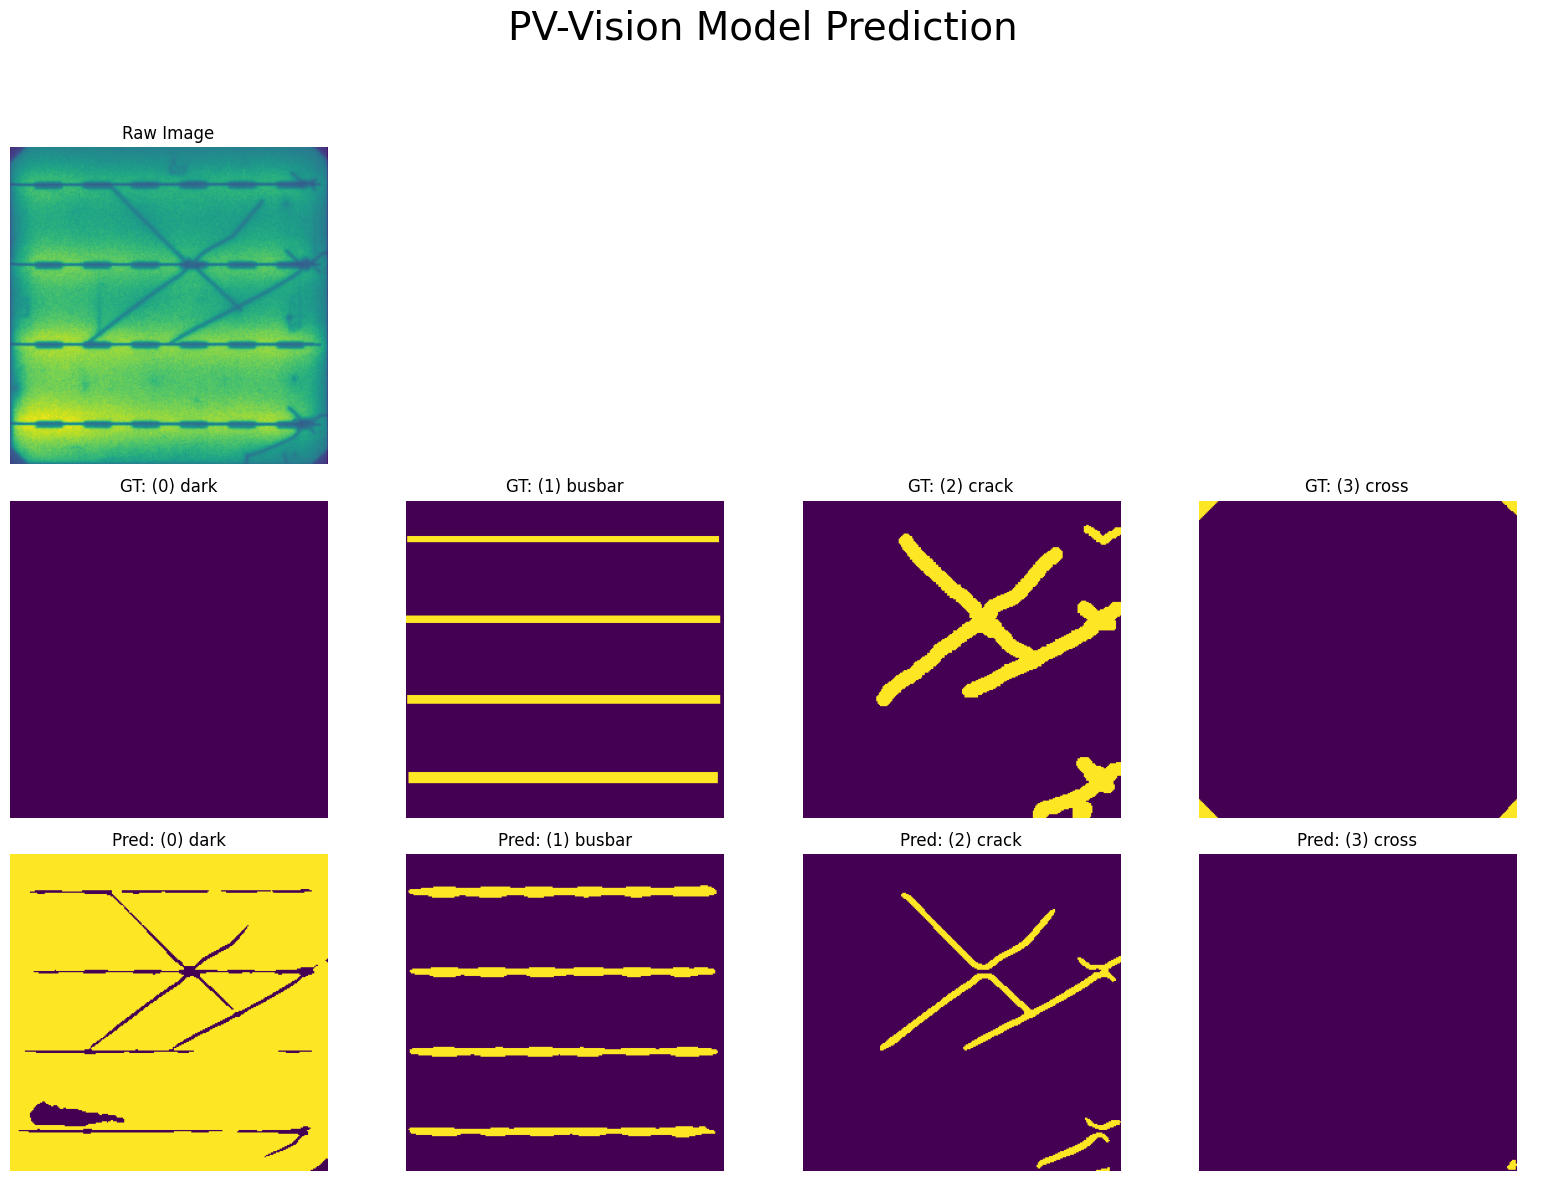

In [21]:
viz_functions.channeled_inference_and_show(
    val_loader,
    device=device,
    model=model_pvvision,
    category_mapping=category_mapping,
    idx=171,
    threshold=0.5,
    custom_title="PV-Vision Model Prediction",
    save_path="pv_vision_model_prediction.png",
)

In [22]:
# All images
m_idx = len(val_dataset)  # indices to process
masks_pvv = []
impaths_pvv = []

for i in range(m_idx):
    img, _ = val_dataset.__getitem__(i)
    img = img.to(device)
    img_path = val_dataset.get_img_path(i)

    # model inference
    logits = model_pvvision(img.unsqueeze(0)).detach().cpu()
    probs = torch.sigmoid(logits)
    pred_mask = (probs > threshold).float().squeeze(0).numpy()  # (n_classes, H, W)

    # Extract crack channel (index 2) and convert to uint8 [0,255]
    crack_mask = (pred_mask[2] * 255).astype(np.uint8)

    masks_pvv.append(crack_mask)
    impaths_pvv.append(str(img_path))

# Build dataframe of image paths expected by feature_extraction_crack_mask
df_info_pvv = pd.DataFrame({"impath": impaths_pvv})

if os.path.exists("df_features_pvv.pickle"):
    df_features_pvv = pd.read_pickle("df_features_pvv.pickle")
else:
    # Run PVImage feature extraction across all predicted crack masks
    df_features_pvv = features.feature_extraction_crack_mask(masks_pvv, df_info_pvv)
    df_features_pvv["count_features"] = df_features_pvv.groupby("cell_number")[
        "cell_number"
    ].transform("count")
    df_features_pvv.to_pickle("df_features_pvv.pickle")

df_features_pvv_count = df_features_pvv.sort_values(by="cell_number").drop_duplicates(
    "cell_number", keep="first"
)
df_features_pvv_count.reset_index(drop=True, inplace=True)

features_counted_pvv = pd.concat(
    [df_features_pvv_count["count_features"]], axis=1, ignore_index=True
)
features_counted_pvv.columns = ["Original"]

# Show basic outputs
print(
    f"Processed {len(masks_pvv)} images, extracted {len(df_features_pvv)} feature rows."
)

# vp = violinplt(features_counted_pvv[["Original"]], figsize=(5, 4))

Processed 468 images, extracted 772 feature rows.


In [23]:
scaler = MinMaxScaler()
columnstonormalize = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
df_features_pvv_norm = df_features_pvv[columnstonormalize]
df_features_pvv_norm[columnstonormalize] = scaler.fit_transform(df_features_pvv_norm)

# fig = violinplt(
#     df_features_pvv_norm[
#         [
#             " prop.perimeter",
#             " slope",
#             " prop.area",
#             " prop.orientation",
#         ]
#     ],
#     figsize=None,
# )

Text(0.5, 1.0, 'Crack masks: PV-Vision vs MultiSolSegment vs Ground Truth')

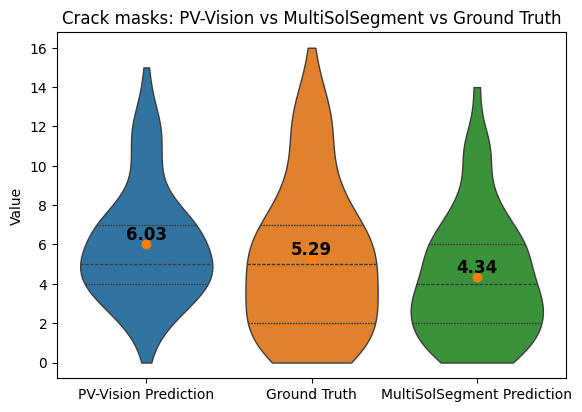

In [24]:
pvv_counts = df_features_pvv.groupby("cell_number").size().rename("pvv_crack_count")

count_comparison_pvv_gt = (
    pd.concat([pvv_counts, gt_counts, mss_counts], axis=1).fillna(0).astype(int).reset_index()
)
count_comparison_pvv_gt.columns = ["cell_number", "pvv_crack_count", "gt_crack_count", "mss_crack_count"]

vp = violinplt(
    count_comparison_pvv_gt[["pvv_crack_count", "gt_crack_count", "mss_crack_count"]].rename(
        columns={
            "mss_crack_count": "MultiSolSegment Prediction",
            "pvv_crack_count": "PV-Vision Prediction",
            "gt_crack_count": "Ground Truth",
        }
    ),
    figsize=(6, 4),
)
plt.title("Crack masks: PV-Vision vs MultiSolSegment vs Ground Truth")

In [25]:
feature_cols = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
feature_comparison = pd.DataFrame(
    {
        "Predicted_mean": df_features_pvv_norm[feature_cols].mean(),
        "GroundTruth_mean": df_features_gt_norm[feature_cols].mean(),
    }
)
feature_comparison["abs_diff"] = (
    feature_comparison["Predicted_mean"] - feature_comparison["GroundTruth_mean"]
).abs()


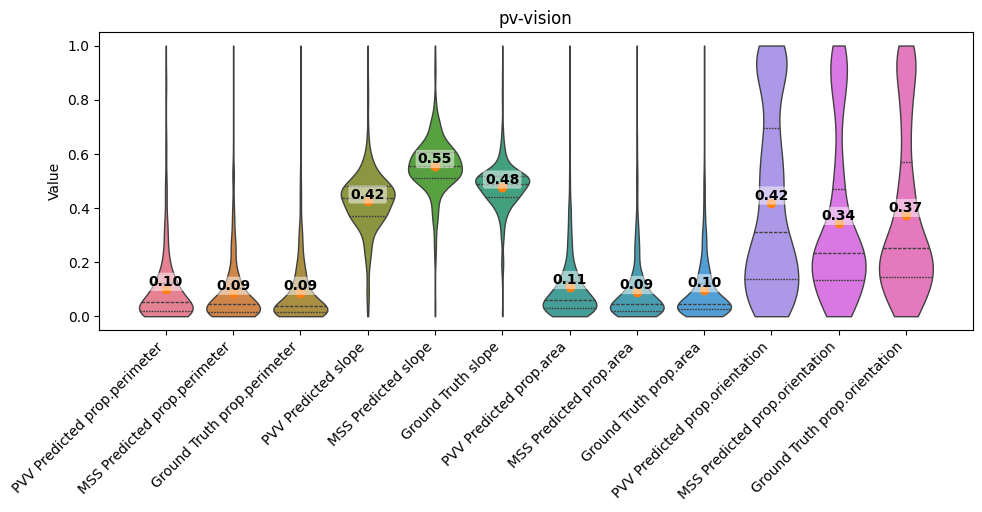

In [26]:
feature_sets_pvv_mss_gt = []

for col in feature_cols:
    if (
        col not in df_features_pvv_norm.columns
        or col not in df_features_gt_norm.columns
    ):
        print(f"Skipping {col}: not found in features dataframe.")
        continue

    label = col.strip()
    pvv_pred = df_features_pvv_norm[col].reset_index(drop=True)
    mss_pred = df_features_mss_norm[col].reset_index(drop=True)
    gt = df_features_gt_norm[col].reset_index(drop=True)

    max_len = max(len(pvv_pred), len(mss_pred), len(gt))
    if max_len == 0:
        print(f"Skipping {label}: no data to plot.")
        continue

    pvv_pred = pvv_pred.reindex(range(max_len))
    mss_pred = mss_pred.reindex(range(max_len))
    gt = gt.reindex(range(max_len))

    feature_sets_pvv_mss_gt.append(
        pd.DataFrame(
            {
                f"PVV Predicted {label}": pvv_pred,
                f"MSS Predicted {label}": mss_pred,
                f"Ground Truth {label}": gt,
            }
        )
    )

if not feature_sets_pvv_mss_gt:
    print("No feature data available for violin plots.")
    feature_violin_pvv_mss_gt_df = pd.DataFrame()
else:
    feature_violin_pvv_mss_gt_df = pd.concat(feature_sets_pvv_mss_gt, axis=1)
    feature_violin_pvv_mss_gt_df = feature_violin_pvv_mss_gt_df.apply(pd.to_numeric, errors="coerce")
    feature_violin_pvv_mss_gt_df = feature_violin_pvv_mss_gt_df.dropna(axis=1, how="all")
    if feature_violin_pvv_mss_gt_df.empty:
        print("No numeric feature data available for violin plots.")
    else:
        # Render comparison violins
        vp = violinplt(feature_violin_pvv_mss_gt_df, figsize=(10, 5))
        plt.title("pv-vision")

## Other Benchmarking metrics

In [27]:
# number of samples in the val set
m_idx = len(val_dataset)

# prepare lists to collect results
impaths = []
masks_multisolseg = []
masks_pvvision = []

for i in range(m_idx):
    # pull out the i-th sample and its path
    img, _ = val_dataset[i]
    img = img.to(device)
    img_path = val_dataset.get_img_path(i)

    impaths.append(str(img_path))

    # --- inference with multisolseg model ---
    with torch.no_grad():
        logits_ms = model(img.unsqueeze(0)).cpu()  # (1, n_classes, H, W)
        probs_ms = torch.sigmoid(logits_ms)  # same shape
        pred_ms = (probs_ms > threshold).float().squeeze(0).numpy()
    # extract crack channel #2, scale to [0,255]
    dark_ms = (pred_ms[0] * 255).astype(np.uint8)
    bb_ms = (pred_ms[1] * 255).astype(np.uint8)
    crack_ms = (pred_ms[2] * 255).astype(np.uint8)
    masks_multisolseg.append([dark_ms, bb_ms, crack_ms])

    # --- inference with pv-vision model ---
    with torch.no_grad():
        logits_pv = model_pvvision(img.unsqueeze(0)).cpu()
        probs_pv = torch.sigmoid(logits_pv)
        pred_pv = (probs_pv > threshold).float().squeeze(0).numpy()
    dark_pv = (pred_pv[0] * 255).astype(np.uint8)
    bb_pv = (pred_pv[1] * 255).astype(np.uint8)
    crack_pv = (pred_pv[2] * 255).astype(np.uint8)
    masks_pvvision.append([dark_pv, bb_pv, crack_pv])

In [28]:
# number of samples in the val set (same as before)
m_idx = len(val_dataset)

masks_gt = []
for i in range(m_idx):
    _, mask = val_dataset[i]
    mask_np = mask.cpu().numpy()  # → shape (n_classes, H, W)

    dark_gt = (mask_np[0] > 0).astype(np.uint8)  # bool→0/1→uint8
    bb_gt = (mask_np[1] > 0).astype(np.uint8)
    crack_gt = (mask_np[2] > 0).astype(np.uint8)

    masks_gt.append([dark_gt, bb_gt, crack_gt])

In [ ]:
# ----------------------------------------------------------------------------
# helper to compute IoU on two boolean masks
def compute_iou(gt: np.ndarray, pred: np.ndarray) -> float:
    inter = np.logical_and(gt, pred).sum()
    union = np.logical_or(gt, pred).sum()
    return float(inter) / union if union > 0 else 0.0


# class names and metric names
classes = ["dark", "busbar", "crack"]
metrics_names = ["Accuracy", "Precision", "Recall", "Dice", "IoU"]

# sanity‐check lengths
assert len(masks_gt) == len(masks_multisolseg) == len(masks_pvvision)
M = len(masks_gt)

# prepare accumulators
results_ms = {c: {m: [] for m in metrics_names} for c in classes}
results_pv = {c: {m: [] for m in metrics_names} for c in classes}

for gt_triplet, ms_triplet, pv_triplet in zip(
    masks_gt, masks_multisolseg, masks_pvvision
):
    for ci, cname in enumerate(classes):
        # boolean masks
        gt_mask = gt_triplet[ci] > 0  # shape (H,W)
        ms_mask = ms_triplet[ci] > 0
        pv_mask = pv_triplet[ci] > 0

        # flatten to vectors for sklearn
        y_true = gt_mask.flatten()
        y_ms = ms_mask.flatten()
        y_pv = pv_mask.flatten()

        # MultisolSegment metrics
        results_ms[cname]["Accuracy"].append(accuracy_score(y_true, y_ms))
        results_ms[cname]["Precision"].append(
            precision_score(y_true, y_ms, zero_division=0)
        )
        results_ms[cname]["Recall"].append(recall_score(y_true, y_ms, zero_division=0))
        results_ms[cname]["Dice"].append(f1_score(y_true, y_ms, zero_division=0))
        results_ms[cname]["IoU"].append(compute_iou(gt_mask, ms_mask))

        # PV-Vision metrics
        results_pv[cname]["Accuracy"].append(accuracy_score(y_true, y_pv))
        results_pv[cname]["Precision"].append(
            precision_score(y_true, y_pv, zero_division=0)
        )
        results_pv[cname]["Recall"].append(recall_score(y_true, y_pv, zero_division=0))
        results_pv[cname]["Dice"].append(f1_score(y_true, y_pv, zero_division=0))
        results_pv[cname]["IoU"].append(compute_iou(gt_mask, pv_mask))

n_classes = len(classes)
n_metrics = len(metrics_names)

avg_ms = np.zeros((n_classes, n_metrics), dtype=float)
avg_pv = np.zeros_like(avg_ms)

for ci, cname in enumerate(classes):
    for mi, mname in enumerate(metrics_names):
        avg_ms[ci, mi] = np.mean(results_ms[cname][mname])
        avg_pv[ci, mi] = np.mean(results_pv[cname][mname])

# --- ADDED: Overall (Macro Average) Calculation ---
overall_ms = np.mean(avg_ms, axis=0)
overall_pv = np.mean(avg_pv, axis=0)

# Extend classes list with 'Overall'
classes.append("Overall")
n_classes += 1

# Extend avg arrays to include Overall
avg_ms = np.vstack([avg_ms, overall_ms])
avg_pv = np.vstack([avg_pv, overall_pv])

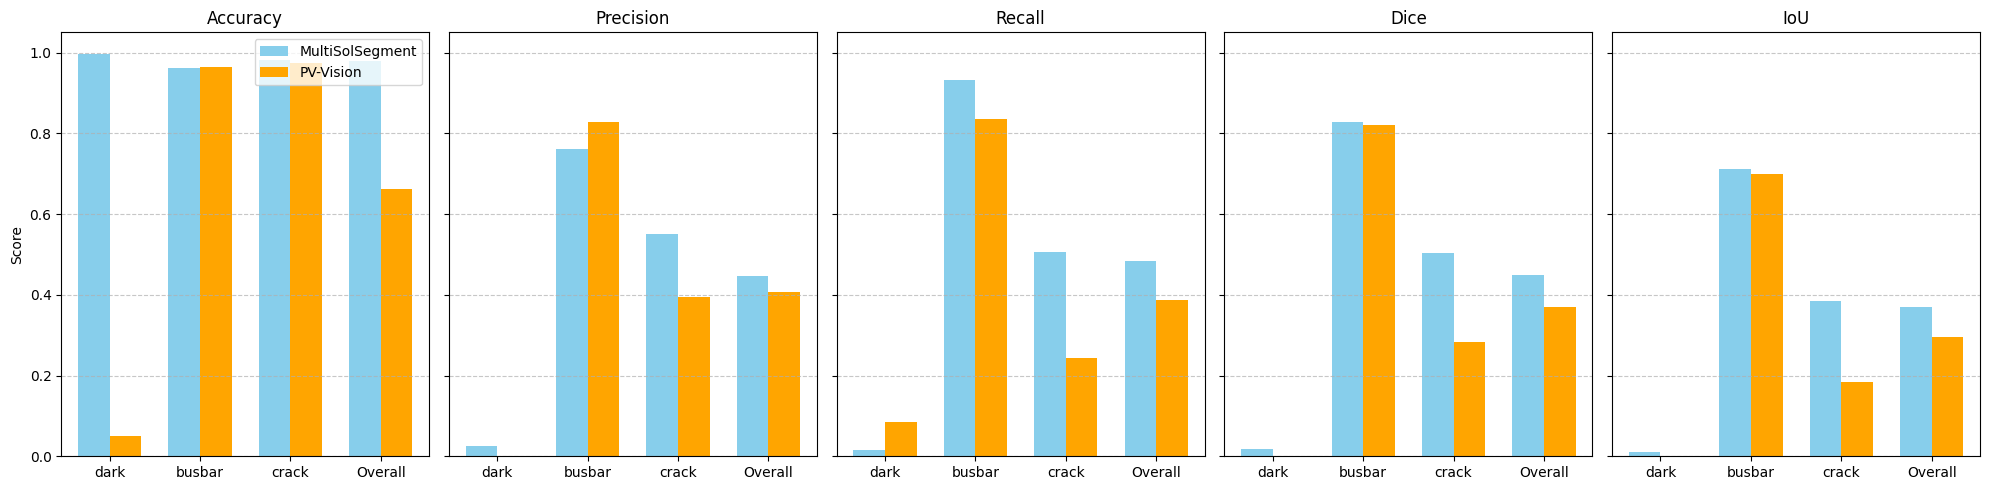

In [30]:
# Set up the plot
fig, axes = plt.subplots(1, n_metrics, figsize=(20, 5), sharey=True)
if n_metrics == 1:
    axes = [axes]

x = np.arange(n_classes)
width = 0.35

# Plot each metric in a separate subplot
for i, metric in enumerate(metrics_names):
    ax = axes[i]

    # Get values for this metric across all classes
    ms_values = avg_ms[:, i]
    pv_values = avg_pv[:, i]

    rects1 = ax.bar(
        x - width / 2, ms_values, width, label="MultiSolSegment", color="skyblue"
    )
    rects2 = ax.bar(x + width / 2, pv_values, width, label="PV-Vision", color="orange")

    ax.set_title(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.set_ylim(0, 1.05)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    if i == 0:
        ax.set_ylabel("Score")
        # Add legend only to the first subplot
        ax.legend()

plt.tight_layout()
plt.show()

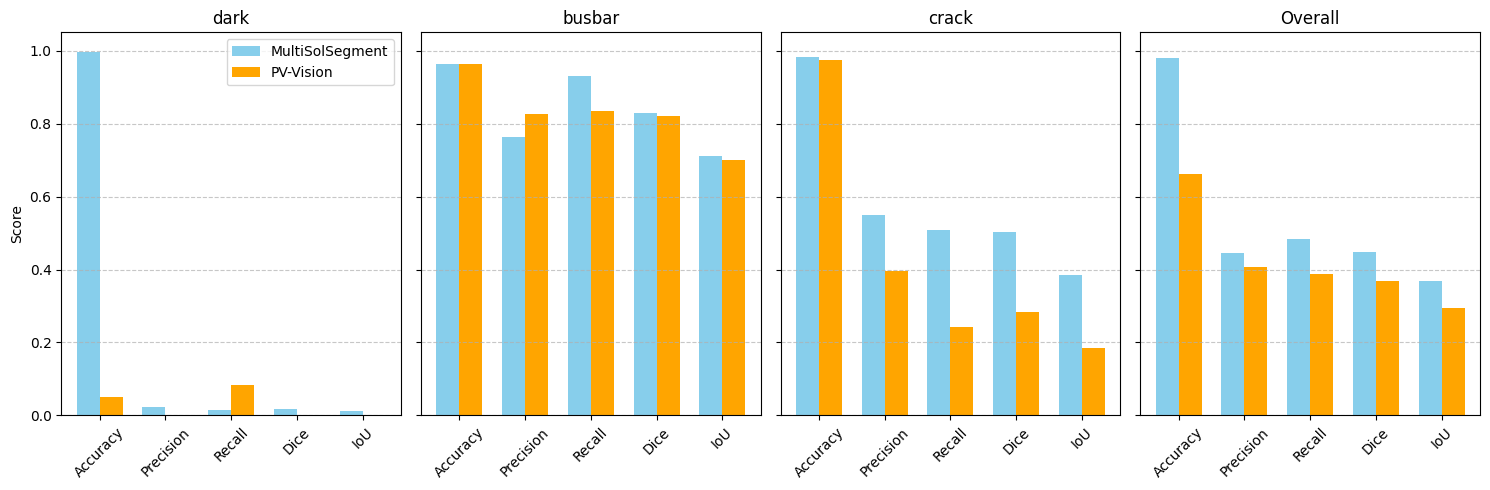

In [31]:
# New visualization: Subplots by Class
fig, axes = plt.subplots(1, n_classes, figsize=(15, 5), sharey=True)
if n_classes == 1:
    axes = [axes]

x = np.arange(n_metrics)
width = 0.35

for i, cname in enumerate(classes):
    ax = axes[i]

    # Get values for this class across all metrics
    # avg_ms shape is (n_classes, n_metrics)
    ms_values = avg_ms[i, :]
    pv_values = avg_pv[i, :]

    rects1 = ax.bar(
        x - width / 2, ms_values, width, label="MultiSolSegment", color="skyblue"
    )
    rects2 = ax.bar(x + width / 2, pv_values, width, label="PV-Vision", color="orange")

    ax.set_title(cname)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names, rotation=45)
    ax.set_ylim(0, 1.05)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    if i == 0:
        ax.set_ylabel("Score")
        ax.legend()

plt.tight_layout()
plt.show()